# Quick Draw GAN

A Generative Adversarial Network trained of the Google Quickdraw dataset found here: https://github.com/googlecreativelab/quickdraw-dataset#preprocessed-dataset

Created in tf.keras

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.keras as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation,Reshape
from keras.layers import BatchNormalization, Conv2D,Flatten, Conv2DTranspose, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,TensorBoard
from time import time

## Helper Functions

In [3]:
from helpers import get_np,imshow,get_callbacks

## Load the Data

In [4]:
inp_path = 'full_numpy_bitmap_apple.npy'
data = get_np(inp_path)
img_w,img_h = data.shape[1:3]

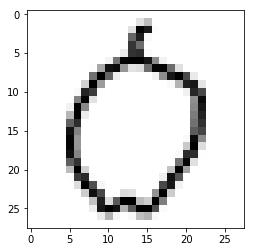

In [5]:
imshow(data,1040)

In [6]:
data.shape

(144722, 28, 28, 1)

# Discriminator

In [7]:
def discriminator_builder(width = 64,p=0.4):
    #Inputs
    inputs=  Input((img_w,img_h,1))
    
    #Model Layers
    conv1 = Conv2D(width*1,5,strides=2,padding='same',activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2,5,strides=2,padding='same',activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4,5,strides=2,padding='same',activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8,5,strides=1,padding='same',activation='relu')(conv3)
    conv4 = Dropout(p)(conv4)
    conv4 = Flatten()(conv4)
    
    output = Dense(1,activation='sigmoid')(conv4)
    
    #Model Definiton
    discriminator = Model(inputs,output)
    discriminator.summary()
    return discriminator

In [8]:
discriminator = discriminator_builder()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)    

In [9]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics = ['acc'])

# Generator

In [10]:
def generator_builder(z_dims = 100,depth = 64,p = 0.4):
    #inputs
    inputs = Input((z_dims,))
    
    #Dense
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation('relu')(dense1)
    
    #Reshape to (7,7,64) tensor
    reshaper = Reshape((7,7,64))(dense1)
    reshaper = BatchNormalization()(reshaper)
    reshaper = Dropout(p)(reshaper)
    
    #Deconvoliutions
    deconv1 = UpSampling2D()(reshaper)
    deconv1 = Conv2DTranspose(int(depth/2),kernel_size=5,padding='same')(deconv1)
    deconv1 = BatchNormalization(momentum=0.9)(deconv1)
    deconv1 = Activation('relu')(deconv1)
    
    deconv2 = UpSampling2D()(deconv1)
    deconv2 = Conv2DTranspose(int(depth/4),kernel_size=5,padding='same')(deconv2)
    deconv2 = BatchNormalization(momentum=0.9)(deconv2)
    deconv2 = Activation('relu')(deconv2)
    
    deconv3 = Conv2DTranspose(int(depth/8),kernel_size=5,padding='same')(deconv2)
    deconv3 = BatchNormalization(momentum=0.9)(deconv3)
    deconv3 = Activation('relu')(deconv3)
    
    #Output
    output = Conv2D(1,kernel_size=5,padding='same',activation='sigmoid')(deconv3)
    model = Model(inputs,output)
    model.summary()
    return model

In [17]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
__________

# GAN

In [18]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    model.summary()
    return model

In [19]:
adversarial_model = adversarial_builder()
adversarial_model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         397217    
_________________________________________________________________
model (Model)                (None, 1)                 4311553   
Total params: 4,708,770
Trainable params: 390,705
Non-trainable params: 4,318,065
_________________________________________________________________


In [20]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [21]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))
        
        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)
            ###########
            imshow(fake_imgs,5)
            ##########
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [22]:
a_metrics_complete, d_metrics_complete = train(epochs=300)

0


InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,28,28,1]
	 [[{{node input_1}}]]